<a href="https://colab.research.google.com/github/arnavsinghal09/GSoC-QMAML/blob/main/Quark_Gluon_Classification_MAML_with_Jet_Mass_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 1. Imports

import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import random
import matplotlib.pyplot as plt

In [ ]:
# 2. Hyperparameters

DATA_DIR = "/content/drive/MyDrive/quark-gluon-dataset"
FILES = [
    "quark-gluon_train-set_n793900.hdf5",
    "quark-gluon_test-set_n139306.hdf5",
    "quark-gluon_test-set_n10000.hdf5"
]
FILE_PATHS = [f"{DATA_DIR}/{fname}" for fname in FILES]
FILE_LABELS = ["Train", "Test1", "Test2"]

BATCH_SIZE = 64
LEARNING_RATE = 1e-4
EPOCHS = 25
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SHAPE = (3, 125, 125)
N_WAY = 2
K_SHOT = 32
K_QUERY = 64
META_BATCH_SIZE = 8
INNER_STEPS = 10
INNER_LR = 0.02
NUM_WORKERS = 2
ADAPTATION_STEPS = 10

In [ ]:
# 3. Dataset and Task Sampler

class JetImageDataset(Dataset):
    def __init__(self, X, y, mass=None, mass_bins=None):
        self.X = X
        self.y = y
        self.mass = mass
        self.mass_bins = mass_bins
        if self.mass is not None and self.mass_bins is not None:
            self.bin_indices = []
            for i in range(len(mass_bins) - 1):
                idx = np.where((mass >= mass_bins[i]) & (mass < mass_bins[i+1]))[0]
                self.bin_indices.append(idx)
        else:
            self.bin_indices = [np.arange(len(y))]
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        x = self.X[idx]
        if x.shape != IMG_SHAPE:
            x = np.transpose(x, (2, 0, 1))
        label = int(self.y[idx])
        return torch.tensor(x, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [ ]:
# 4. Model (Smaller CNN for MAML)

class JetCNN(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=2, padding=2), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 256), nn.ReLU(),
            nn.Linear(256, n_classes)
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
# 5. Data Preparation and Meta-Task Definition

with h5py.File(FILE_PATHS[0], "r") as f:
    X = np.array(f["X_jets"][:100000])  # Use a manageable subset for Colab
    y = np.array(f["y"][:100000])
    pt = np.array(f["pt"][:100000])
    m0 = np.array(f["m0"][:50000])

mass_bins = np.percentile(m0, np.linspace(0, 100, 6))
print("Jet mass bins:", mass_bins)

jet_dataset = JetImageDataset(X, y, mass=m0, mass_bins=mass_bins)

indices = np.arange(len(y))
np.random.shuffle(indices)
split = int(0.8 * len(indices))
train_idx, val_idx = indices[:split], indices[split:]
train_loader = DataLoader(
    Subset(jet_dataset, train_idx),
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=NUM_WORKERS
)
val_loader = DataLoader(
    Subset(jet_dataset, val_idx),
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=NUM_WORKERS
)

Jet mass bins: [ 2.73585939 15.95369186 18.85825195 21.76700401 25.78765755 78.60527802]


In [ ]:
# 6. Training Loop for Classical Baseline

def compute_metrics(y_true, y_pred):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    return acc, f1, prec, rec

def train_baseline(model, train_loader, val_loader, epochs=EPOCHS):
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        y_true_train, y_pred_train = [], []
        for X, y in train_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            logits = model(X)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X.size(0)
            preds = logits.argmax(dim=1)
            y_true_train.append(y)
            y_pred_train.append(preds)
        y_true_train = torch.cat(y_true_train)
        y_pred_train = torch.cat(y_pred_train)
        train_loss /= len(train_loader.dataset)
        train_acc, train_f1, train_prec, train_rec = compute_metrics(y_true_train, y_pred_train)

        # Validation
        model.eval()
        val_loss = 0
        y_true_val, y_pred_val = [], []
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(DEVICE), y.to(DEVICE)
                logits = model(X)
                loss = loss_fn(logits, y)
                val_loss += loss.item() * X.size(0)
                preds = logits.argmax(dim=1)
                y_true_val.append(y)
                y_pred_val.append(preds)
        y_true_val = torch.cat(y_true_val)
        y_pred_val = torch.cat(y_pred_val)
        val_loss /= len(val_loader.dataset)
        val_acc, val_f1, val_prec, val_rec = compute_metrics(y_true_val, y_pred_val)

        print(f"Epoch {epoch+1:2d} | "
              f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f} | "
              f"Prec: {train_prec:.4f} | Rec: {train_rec:.4f} || "
              f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f} | "
              f"Prec: {val_prec:.4f} | Rec: {val_rec:.4f}")
    return model

In [ ]:
# 7. MAML Meta-Learning Loop

def forward_with_weights(x, weights):
    # Conv1
    x = nn.functional.conv2d(x, weights[0], weights[1], stride=2, padding=2)
    x = nn.functional.relu(x)
    # Conv2
    x = nn.functional.conv2d(x, weights[2], weights[3], stride=2, padding=1)
    x = nn.functional.relu(x)
    # Conv3
    x = nn.functional.conv2d(x, weights[4], weights[5], stride=2, padding=1)
    x = nn.functional.relu(x)
    # Conv4
    x = nn.functional.conv2d(x, weights[6], weights[7], stride=2, padding=1)
    x = nn.functional.relu(x)
    # Flatten
    x = x.view(x.size(0), -1)
    # FC1
    x = nn.functional.linear(x, weights[8], weights[9])
    x = nn.functional.relu(x)
    # FC2
    x = nn.functional.linear(x, weights[10], weights[11])
    return x

def maml_train(model, dataset, mass_bins, meta_batch_size=META_BATCH_SIZE, epochs=EPOCHS):
    model = model.to(DEVICE)
    meta_optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        meta_loss = 0
        all_y_true, all_y_pred = [], []
        for _ in range(meta_batch_size):
            bin_idx = random.randint(0, len(mass_bins)-2)
            (X_s, y_s), (X_q, y_q) = sample_task(dataset, bin_idx, K_SHOT, K_QUERY)
            X_s, y_s, X_q, y_q = X_s.to(DEVICE), y_s.to(DEVICE), X_q.to(DEVICE), y_q.to(DEVICE)
            fast_weights = [p.clone().detach().requires_grad_(True) for p in model.parameters()]
            for _ in range(INNER_STEPS):
                logits = forward_with_weights(X_s, fast_weights)
                loss = loss_fn(logits, y_s)
                grads = torch.autograd.grad(loss, fast_weights, create_graph=True)
                fast_weights = [w - INNER_LR * g for w, g in zip(fast_weights, grads)]
            logits_q = forward_with_weights(X_q, fast_weights)
            loss_q = loss_fn(logits_q, y_q)
            meta_loss += loss_q
            preds = logits_q.argmax(dim=1)
            all_y_true.append(y_q)
            all_y_pred.append(preds)
        meta_optimizer.zero_grad()
        meta_loss.backward()
        meta_optimizer.step()
        all_y_true = torch.cat(all_y_true)
        all_y_pred = torch.cat(all_y_pred)
        acc, f1, prec, rec = compute_metrics(all_y_true, all_y_pred)
        print(f"Epoch {epoch+1:2d} | Meta Loss: {meta_loss.item()/meta_batch_size:.4f} | "
              f"Acc: {acc:.4f} | F1: {f1:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f}")
    return model

In [ ]:
# Sample task function for meta-learning

def sample_task(dataset, bin_idx, k_shot, k_query):
    idxs = dataset.bin_indices[bin_idx]
    idxs = np.random.permutation(idxs)
    support_idxs = idxs[:k_shot]
    query_idxs = idxs[k_shot:k_shot + k_query]
    X_s, y_s = zip(*[dataset[i] for i in support_idxs])
    X_q, y_q = zip(*[dataset[i] for i in query_idxs])
    return (torch.stack(X_s), torch.tensor(y_s)), (torch.stack(X_q), torch.tensor(y_q))

In [ ]:
# 8. Train and Evaluate Baseline

baseline_model = JetCNN()
baseline_model = train_baseline(baseline_model, train_loader, val_loader)

Epoch  1 | Train Loss: 0.6692 | Acc: 0.5636 | F1: 0.6205 | Prec: 0.5497 | Rec: 0.7121 || Val Loss: 0.6075 | Acc: 0.6796 | F1: 0.6884 | Prec: 0.6627 | Rec: 0.7162
Epoch  2 | Train Loss: 0.5993 | Acc: 0.6895 | F1: 0.6999 | Prec: 0.6784 | Rec: 0.7227 || Val Loss: 0.6021 | Acc: 0.6872 | F1: 0.6910 | Prec: 0.6750 | Rec: 0.7077
Epoch  3 | Train Loss: 0.5948 | Acc: 0.6920 | F1: 0.7029 | Prec: 0.6801 | Rec: 0.7272 || Val Loss: 0.5992 | Acc: 0.6904 | F1: 0.6939 | Prec: 0.6785 | Rec: 0.7100
Epoch  4 | Train Loss: 0.5917 | Acc: 0.6944 | F1: 0.7052 | Prec: 0.6824 | Rec: 0.7296 || Val Loss: 0.5975 | Acc: 0.6926 | F1: 0.6962 | Prec: 0.6806 | Rec: 0.7125
Epoch  5 | Train Loss: 0.5894 | Acc: 0.6956 | F1: 0.7069 | Prec: 0.6828 | Rec: 0.7327 || Val Loss: 0.5991 | Acc: 0.6855 | F1: 0.6580 | Prec: 0.7113 | Rec: 0.6121
Epoch  6 | Train Loss: 0.5865 | Acc: 0.6972 | F1: 0.7073 | Prec: 0.6856 | Rec: 0.7304 || Val Loss: 0.5970 | Acc: 0.6899 | F1: 0.7189 | Prec: 0.6513 | Rec: 0.8022
Epoch  7 | Train Loss: 0.577

In [ ]:
# 9. Train and Evaluate MAML

maml_model = JetCNN()
maml_model = maml_train(maml_model, jet_dataset, mass_bins)

Epoch  1 | Meta Loss: 0.6831 | Acc: 0.5781 | F1: 0.2603 | Prec: 0.5938 | Rec: 0.1667
Epoch  2 | Meta Loss: 0.6821 | Acc: 0.5957 | F1: 0.4329 | Prec: 0.6172 | Rec: 0.3333
Epoch  3 | Meta Loss: 0.6828 | Acc: 0.5898 | F1: 0.5474 | Prec: 0.6615 | Rec: 0.4669
Epoch  4 | Meta Loss: 0.6832 | Acc: 0.5859 | F1: 0.5970 | Prec: 0.6133 | Rec: 0.5815
Epoch  5 | Meta Loss: 0.6915 | Acc: 0.5039 | F1: 0.3744 | Prec: 0.5938 | Rec: 0.2734
Epoch  6 | Meta Loss: 0.6810 | Acc: 0.6445 | F1: 0.4830 | Prec: 0.6641 | Rec: 0.3795
Epoch  7 | Meta Loss: 0.6871 | Acc: 0.5254 | F1: 0.2569 | Prec: 0.6562 | Rec: 0.1597
Epoch  8 | Meta Loss: 0.6899 | Acc: 0.5273 | F1: 0.2143 | Prec: 0.5156 | Rec: 0.1352
Epoch  9 | Meta Loss: 0.6813 | Acc: 0.5938 | F1: 0.5498 | Prec: 0.6615 | Rec: 0.4704
Epoch 10 | Meta Loss: 0.6829 | Acc: 0.5840 | F1: 0.5380 | Prec: 0.6458 | Rec: 0.4610
Epoch 11 | Meta Loss: 0.6787 | Acc: 0.5957 | F1: 0.2983 | Prec: 0.6875 | Rec: 0.1905


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12 | Meta Loss: 0.6890 | Acc: 0.4902 | F1: 0.0000 | Prec: 0.0000 | Rec: 0.0000
Epoch 13 | Meta Loss: 0.6833 | Acc: 0.5801 | F1: 0.4869 | Prec: 0.7969 | Rec: 0.3505
Epoch 14 | Meta Loss: 0.6891 | Acc: 0.5410 | F1: 0.2857 | Prec: 0.7344 | Rec: 0.1774
Epoch 15 | Meta Loss: 0.6871 | Acc: 0.5938 | F1: 0.4694 | Prec: 0.7188 | Rec: 0.3485
Epoch 16 | Meta Loss: 0.6784 | Acc: 0.6172 | F1: 0.5525 | Prec: 0.6302 | Rec: 0.4919
Epoch 17 | Meta Loss: 0.6802 | Acc: 0.6016 | F1: 0.2917 | Prec: 0.6562 | Rec: 0.1875
Epoch 18 | Meta Loss: 0.6777 | Acc: 0.6445 | F1: 0.5027 | Prec: 0.7188 | Rec: 0.3866
Epoch 19 | Meta Loss: 0.6930 | Acc: 0.4980 | F1: 0.3219 | Prec: 0.4766 | Rec: 0.2430
Epoch 20 | Meta Loss: 0.6798 | Acc: 0.6387 | F1: 0.5952 | Prec: 0.7083 | Rec: 0.5132
Epoch 21 | Meta Loss: 0.6843 | Acc: 0.6250 | F1: 0.6308 | Prec: 0.6406 | Rec: 0.6212
Epoch 22 | Meta Loss: 0.6854 | Acc: 0.5566 | F1: 0.2928 | Prec: 0.7344 | Rec: 0.1829
Epoch 23 | Meta Loss: 0.6789 | Acc: 0.6562 | F1: 0.5829 | Prec: 0

In [ ]:
# 10. Few-Shot Evaluation Function

def few_shot_eval(model, dataset, mass_bins, n_tasks=None, k_shot=K_SHOT, k_query=K_QUERY, inner_steps=INNER_STEPS, inner_lr=INNER_LR):
    model.eval()
    all_acc, all_f1, all_prec, all_rec = [], [], [], []
    n_bins = len(mass_bins) - 1 if n_tasks is None else n_tasks
    for bin_idx in range(n_bins):
        (X_s, y_s), (X_q, y_q) = sample_task(dataset, bin_idx, k_shot, k_query)
        X_s, y_s, X_q, y_q = X_s.to(DEVICE), y_s.to(DEVICE), X_q.to(DEVICE), y_q.to(DEVICE)
        # Fast adaptation (inner loop)
        fast_weights = [p.clone().detach().requires_grad_(True) for p in model.parameters()]
        loss_fn = nn.CrossEntropyLoss()
        for _ in range(inner_steps):
            logits = model(X_s)
            loss = loss_fn(logits, y_s)
            grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
            fast_weights = [w - inner_lr * g for w, g in zip(fast_weights, grads)]
        # Evaluate on query set
        def forward_with_weights(x, weights):
            # Conv1
            x = nn.functional.conv2d(x, weights[0], weights[1], stride=2, padding=2)
            x = nn.functional.relu(x)
            # Conv2
            x = nn.functional.conv2d(x, weights[2], weights[3], stride=2, padding=1)
            x = nn.functional.relu(x)
            # Conv3
            x = nn.functional.conv2d(x, weights[4], weights[5], stride=2, padding=1)
            x = nn.functional.relu(x)
            # Conv4
            x = nn.functional.conv2d(x, weights[6], weights[7], stride=2, padding=1)
            x = nn.functional.relu(x)
            # Flatten
            x = x.view(x.size(0), -1)
            # FC1
            x = nn.functional.linear(x, weights[8], weights[9])
            x = nn.functional.relu(x)
            # FC2
            x = nn.functional.linear(x, weights[10], weights[11])
            return x
        logits_q = forward_with_weights(X_q, fast_weights)
        preds = logits_q.argmax(dim=1)
        acc = accuracy_score(y_q.cpu().numpy(), preds.cpu().numpy())
        f1 = f1_score(y_q.cpu().numpy(), preds.cpu().numpy())
        prec = precision_score(y_q.cpu().numpy(), preds.cpu().numpy())
        rec = recall_score(y_q.cpu().numpy(), preds.cpu().numpy())
        all_acc.append(acc)
        all_f1.append(f1)
        all_prec.append(prec)
        all_rec.append(rec)
        print(f"Bin {bin_idx}: Acc={acc:.4f} | F1={f1:.4f} | Prec={prec:.4f} | Rec={rec:.4f}")
    print(f"\nMean Few-Shot: Acc={np.mean(all_acc):.4f} | F1={np.mean(all_f1):.4f} | Prec={np.mean(all_prec):.4f} | Rec={np.mean(all_rec):.4f}")
    return all_acc, all_f1, all_prec, all_rec

In [ ]:
# 11. Few-Shot Evaluation for MAML and Baseline

print("MAML Few-Shot Evaluation:")
few_shot_eval(maml_model, jet_dataset, mass_bins)

print("\nClassical Baseline Few-Shot Evaluation (no adaptation):")
# For baseline, skip adaptation: just forward pass
def baseline_few_shot_eval(model, dataset, mass_bins, n_tasks=None, k_query=K_QUERY):
    model.eval()
    all_acc, all_f1, all_prec, all_rec = [], [], [], []
    n_bins = len(mass_bins) - 1 if n_tasks is None else n_tasks
    for bin_idx in range(n_bins):
        idxs = dataset.bin_indices[bin_idx]
        idxs = np.random.permutation(idxs)
        query_idxs = idxs[:k_query]
        X_q, y_q = zip(*[dataset[i] for i in query_idxs])
        X_q = torch.stack(X_q).to(DEVICE)
        y_q = torch.tensor(y_q).to(DEVICE)
        with torch.no_grad():
            logits_q = model(X_q)
            preds = logits_q.argmax(dim=1)
        acc = accuracy_score(y_q.cpu().numpy(), preds.cpu().numpy())
        f1 = f1_score(y_q.cpu().numpy(), preds.cpu().numpy())
        prec = precision_score(y_q.cpu().numpy(), preds.cpu().numpy())
        rec = recall_score(y_q.cpu().numpy(), preds.cpu().numpy())
        all_acc.append(acc)
        all_f1.append(f1)
        all_prec.append(prec)
        all_rec.append(rec)
        print(f"Bin {bin_idx}: Acc={acc:.4f} | F1={f1:.4f} | Prec={prec:.4f} | Rec={rec:.4f}")
    print(f"\nMean Few-Shot: Acc={np.mean(all_acc):.4f} | F1={np.mean(all_f1):.4f} | Prec={np.mean(all_prec):.4f} | Rec={np.mean(all_rec):.4f}")
    return all_acc, all_f1, all_prec, all_rec

baseline_few_shot_eval(baseline_model, jet_dataset, mass_bins)

MAML Few-Shot Evaluation:
Bin 0: Acc=0.6719 | F1=0.8037 | Prec=0.6719 | Rec=1.0000
Bin 1: Acc=0.5625 | F1=0.7200 | Prec=0.5625 | Rec=1.0000
Bin 2: Acc=0.4688 | F1=0.0000 | Prec=0.0000 | Rec=0.0000
Bin 3: Acc=0.5625 | F1=0.0000 | Prec=0.0000 | Rec=0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bin 4: Acc=0.7812 | F1=0.0000 | Prec=0.0000 | Rec=0.0000

Mean Few-Shot: Acc=0.6094 | F1=0.3047 | Prec=0.2469 | Rec=0.4000

Classical Baseline Few-Shot Evaluation (no adaptation):
Bin 0: Acc=0.6250 | F1=0.7273 | Prec=0.7442 | Rec=0.7111
Bin 1: Acc=0.7812 | F1=0.8511 | Prec=0.8163 | Rec=0.8889
Bin 2: Acc=0.6406 | F1=0.5490 | Prec=0.5385 | Rec=0.5600
Bin 3: Acc=0.7656 | F1=0.7541 | Prec=0.7188 | Rec=0.7931
Bin 4: Acc=0.7812 | F1=0.5625 | Prec=0.5625 | Rec=0.5625

Mean Few-Shot: Acc=0.7188 | F1=0.6888 | Prec=0.6760 | Rec=0.7031


([0.625, 0.78125, 0.640625, 0.765625, 0.78125],
 [0.7272727272727273,
  0.851063829787234,
  0.5490196078431373,
  0.7540983606557377,
  0.5625],
 [0.7441860465116279, 0.8163265306122449, 0.5384615384615384, 0.71875, 0.5625],
 [0.7111111111111111, 0.8888888888888888, 0.56, 0.7931034482758621, 0.5625])

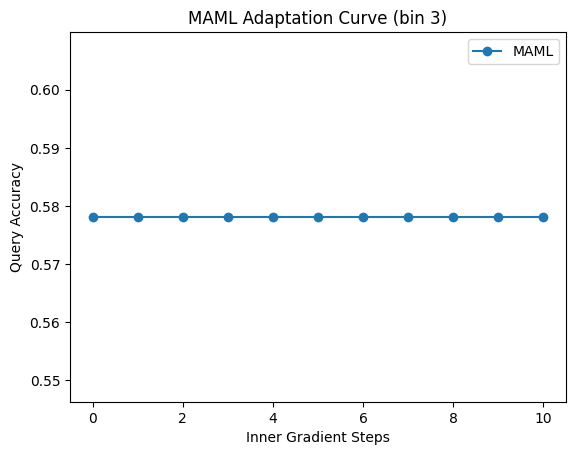

In [ ]:
# Adaptation Curve Evaluation

def adaptation_curve(model, dataset, bin_idx, max_steps=ADAPTATION_STEPS, inner_lr=INNER_LR):
    (X_s, y_s), (X_q, y_q) = sample_task(dataset, bin_idx, K_SHOT, K_QUERY)
    X_s, y_s, X_q, y_q = X_s.to(DEVICE), y_s.to(DEVICE), X_q.to(DEVICE), y_q.to(DEVICE)
    fast_weights = [p.clone().detach().requires_grad_(True) for p in model.parameters()]
    loss_fn = nn.CrossEntropyLoss()
    accs = []
    for step in range(max_steps+1):
        logits_q = forward_with_weights(X_q, fast_weights)
        preds = logits_q.argmax(dim=1)
        acc = accuracy_score(y_q.cpu().numpy(), preds.cpu().numpy())
        accs.append(acc)
        if step < max_steps:
            logits_s = forward_with_weights(X_s, fast_weights)
            loss = loss_fn(logits_s, y_s)
            grads = torch.autograd.grad(loss, fast_weights, create_graph=True)
            fast_weights = [w - inner_lr * g for w, g in zip(fast_weights, grads)]
    return accs

# Plot adaptation curve for a random bin
bin_idx = random.randint(0, len(mass_bins)-2)
maml_accs = adaptation_curve(maml_model, jet_dataset, bin_idx)
plt.plot(range(len(maml_accs)), maml_accs, marker='o', label="MAML")
plt.xlabel("Inner Gradient Steps")
plt.ylabel("Query Accuracy")
plt.title(f"MAML Adaptation Curve (bin {bin_idx})")
plt.legend()
plt.show()

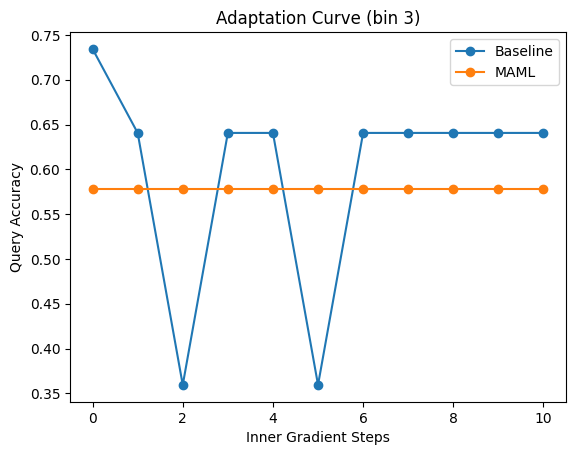

In [ ]:
# Baseline Adaptation Curve (for comparison)

def baseline_adaptation_curve(model, dataset, bin_idx, max_steps=ADAPTATION_STEPS, inner_lr=INNER_LR):
    (X_s, y_s), (X_q, y_q) = sample_task(dataset, bin_idx, K_SHOT, K_QUERY)
    X_s, y_s, X_q, y_q = X_s.to(DEVICE), y_s.to(DEVICE), X_q.to(DEVICE), y_q.to(DEVICE)
    # Start from baseline weights (no meta-learning)
    fast_weights = [p.clone().detach().requires_grad_(True) for p in model.parameters()]
    loss_fn = nn.CrossEntropyLoss()
    accs = []
    for step in range(max_steps+1):
        logits_q = forward_with_weights(X_q, fast_weights)
        preds = logits_q.argmax(dim=1)
        acc = accuracy_score(y_q.cpu().numpy(), preds.cpu().numpy())
        accs.append(acc)
        if step < max_steps:
            logits_s = forward_with_weights(X_s, fast_weights)
            loss = loss_fn(logits_s, y_s)
            grads = torch.autograd.grad(loss, fast_weights, create_graph=True)
            fast_weights = [w - inner_lr * g for w, g in zip(fast_weights, grads)]
    return accs

baseline_accs = baseline_adaptation_curve(baseline_model, jet_dataset, bin_idx)
plt.plot(range(len(baseline_accs)), baseline_accs, marker='o', label="Baseline")
plt.plot(range(len(maml_accs)), maml_accs, marker='o', label="MAML")
plt.xlabel("Inner Gradient Steps")
plt.ylabel("Query Accuracy")
plt.title(f"Adaptation Curve (bin {bin_idx})")
plt.legend()
plt.show()